# Benchmarking DeLOB

In [1]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import numpy as np
import os
from seqwalk import design
from time import time, sleep
import subprocess
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import resource

In [2]:
lib_size = np.linspace(10**3, 2*10**5, 20, dtype=int)
print(lib_size)

d = {
    "Candidate space" : [],
    "Preprocessing time" : [],
    "BLAST time" : [],
    "Number of BLAST records" : [],
    "Network elimination time" : [],
    "Total time" : [],
    "Library size" : [],
    "Peak memory usage (GB)" : []
}

for N in tqdm(lib_size):

    t0 = time()
    
    # generate random seqs
    lib = ["".join(np.random.choice(["A", "C", "G", "T"], size=25)) for _ in range(N)]
    
#     save as FASTA
    seqs = [SeqRecord(Seq(lib[l]), id="seq%d"%l) for l in range(len(lib))]
    SeqIO.write(seqs, "seqs.fasta", "fasta")
    t1 = time()

    cmd= 'blastn -query seqs.fasta -subject seqs.fasta -outfmt 6 -out res -dust no -word_size 11'
    cmd = cmd.split()
    subprocess.Popen(cmd).wait()
    df = pd.read_csv("res", sep='\t', header=None)
#     # only perfect identity
#     df = df[df[2] == 100]
#     # remove identical
#     df = df[df[3] != 25]
#     # remove high HSP
#     df = df[df[3] < 13]

    t2 = time()

    trashbin = set()
    keeper = set()
    for row in df.iterrows():
        if row[1][3] < 13 and row[1][3] != 25: 
            query = row[1][0]
            target = row[1][1]
            if query not in keeper:
                if query not in trashbin:
                    keeper.add(query)
                    trashbin.add(target)
            else:
                trashbin.add(target)

    t3 = time()
    d["Candidate space"].append(N)
    d["Preprocessing time"].append(t1-t0)
    d["Number of BLAST records"].append(len(df))
    d["BLAST time"].append(t2-t1)
    d["Network elimination time"].append(t3-t2)
    d["Total time"].append(t3-t0)
    d["Library size"].append(len(keeper))
    mem = resource.getrusage(resource.RUSAGE_CHILDREN).ru_maxrss/10**6
    d['Peak memory usage (GB)'].append(mem)
#     print("Memory usage (GB): %f" % mem)

[  1000  11473  21947  32421  42894  53368  63842  74315  84789  95263
 105736 116210 126684 137157 147631 158105 168578 179052 189526 200000]


  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
pd.DataFrame(d)

,Candidate space,Preprocessing time,BLAST time,Number of BLAST records,Network elimination time,Total time,Library size,Peak memory usage (GB)
0,1000,0.026478,0.184222,1104,0.025018,0.235718,48,0.194180
1,11473,0.276071,2.117374,22527,0.515503,2.908947,3413,1.033504
2,21947,0.486906,5.592199,62289,1.589978,7.669083,8562,3.462756
3,32421,0.766978,9.246956,121063,3.205425,13.219358,13433,5.183316
4,42894,1.133185,13.592891,197903,4.874260,19.600337,17291,6.949992
5,53368,1.179364,19.423693,292697,7.025400,27.628458,20287,8.764828
6,63842,1.537095,24.202973,407387,10.173935,35.914004,22554,10.634040
7,74315,1.612077,31.417512,537926,13.477209,46.506797,24364,12.608032
8,84789,1.930416,38.088090,690621,17.704804,57.723311,26052,14.600676
9,95263,2.034516,47.308614,857228,21.421981,70.765111,27507,16.632736


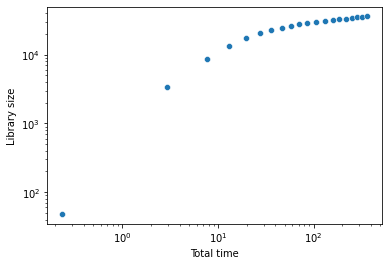

In [13]:
res_df = pd.DataFrame(d)

sns.scatterplot(res_df,
             y="Library size",
             x="Total time")
plt.xscale('log')
plt.yscale('log')

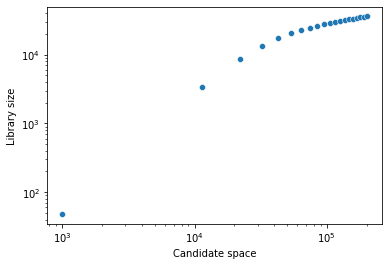

In [14]:
sns.scatterplot(res_df,
             x="Candidate space",
             y="Library size")
plt.xscale('log')
plt.yscale('log')

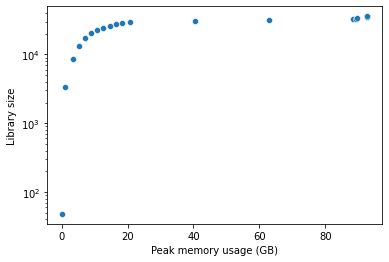

In [15]:
res_df = pd.DataFrame(d)

sns.scatterplot(res_df,
             y="Library size",
             x="Peak memory usage (GB)")

# plt.xscale('log')
plt.yscale('log')

In [7]:
res_df.to_csv("DeLOB_benchmarking.csv")

In [17]:
t0 = time()
library = design.max_size(25, 12, alphabet="ACGT", prevented_patterns=[])
t1 = time()

mem = resource.getrusage(resource.RUSAGE_CHILDREN).ru_maxrss/10**6
print(mem)
print(t1-t0)

92.524928
16.62598490715027


In [9]:
sw_time = t1-t0
sw_ls = len(library)
print(sw_ls)

1198372


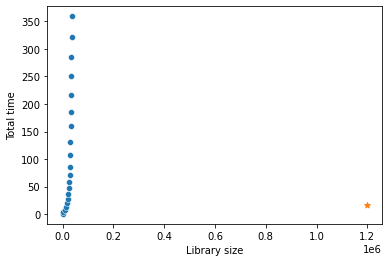

In [10]:
sns.scatterplot(res_df,
             x="Library size",
             y="Total time")
plt.scatter([sw_ls],[sw_time],  marker="*")
# plt.yscale('log')

In [11]:
res_df

,Candidate space,Preprocessing time,BLAST time,Number of BLAST records,Network elimination time,Total time,Library size,Peak memory usage (GB)
0,1000,0.026478,0.184222,1104,0.025018,0.235718,48,0.194180
1,11473,0.276071,2.117374,22527,0.515503,2.908947,3413,1.033504
2,21947,0.486906,5.592199,62289,1.589978,7.669083,8562,3.462756
3,32421,0.766978,9.246956,121063,3.205425,13.219358,13433,5.183316
4,42894,1.133185,13.592891,197903,4.874260,19.600337,17291,6.949992
5,53368,1.179364,19.423693,292697,7.025400,27.628458,20287,8.764828
6,63842,1.537095,24.202973,407387,10.173935,35.914004,22554,10.634040
7,74315,1.612077,31.417512,537926,13.477209,46.506797,24364,12.608032
8,84789,1.930416,38.088090,690621,17.704804,57.723311,26052,14.600676
9,95263,2.034516,47.308614,857228,21.421981,70.765111,27507,16.632736
